In [1]:
import warnings
warnings.filterwarnings("ignore")  

import pandas as pd
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords') #Download NLTK Stopwords for machines that do not have it
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer #stemmer

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer #For TF-IDF
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from keras import utils
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense, Dropout, Embedding, Activation, LSTM, Input, Flatten
from tensorflow.python.keras.layers import SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D

import numpy as np
import re
import string
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

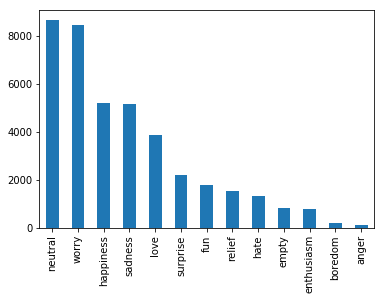

In [3]:
dataframes = {
    "tweets": pd.read_csv("../content/drive/My Drive/Colab Notebooks/datasets/crowdflower_cs.csv", usecols=range(0,2), encoding='latin1'),
    "anger-train": pd.read_csv("../content/drive/My Drive/Colab Notebooks/datasets/saif-2018-anger-train-cs.csv", usecols=range(0,2), encoding='latin1'),
    "joy-train": pd.read_csv("../content/drive/My Drive/Colab Notebooks/datasets/saif-2018-joy-train-cs.csv", usecols=range(0,2), encoding='latin1'),
    "sad-train": pd.read_csv("../content/drive/My Drive/Colab Notebooks/datasets/saif-2018-sadness-train-cs.csv", usecols=range(0,2), encoding='latin1')
}
# print(dataframes["tweets"].iloc[654])

dataframes["tweets"]["sentiment"].value_counts().plot(kind='bar');
dataframes["tweets"]["sentiment"].value_counts()

# dataframes["tweets"].head()
# dataframes["anger-train"].head()
# print(dataframes["sad-train"]["sentiment"].value_counts())

In [0]:
print(dataframes["tweets"].iloc[1])

tweet_id                                            1956967666
sentiment                                              sadness
author                                               wannamama
content      Layin n bed with a headache  ughhhh...waitin o...
Name: 1, dtype: object


In [0]:
# https://www.kaggle.com/jmccabe/text-preprocessing

uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

def stripTagsAndUris(x):
    if x:
        # BeautifulSoup on content
        soup = BeautifulSoup(x, "html.parser")
        # Stripping all <code> tags with their content if any
        if soup.code:
            soup.code.decompose()
        # Get all the text out of the html
        text =  soup.get_text()
        # Returning text stripping out all uris
        return re.sub(uri_re, "", text)
    else:
        return ""

def removePunctuation(x):
    # Lowercasing all words
    x = x.lower()
    # Removing non ASCII chars
    x = re.sub(r'[^\x00-\x7f]',r' ',x)
    # Removing (replacing with empty spaces actually) all the punctuations
    return re.sub("["+string.punctuation+"]", " ", x)

snow = nltk.stem.SnowballStemmer('english')
stops = set(stopwords.words("english"))
def stemAndRemoveStopwords(x):
    # Removing all the stopwords
    filtered_words = [snow.stem(word) for word in x.split() if word not in stops]
    return " ".join(filtered_words)
    
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)    
    return input_txt

switch_Emotions = {
    #happy angry sad neutral
    #anger boredom empty enthusiasm fun happiness hate love neutral relief sadness surprise worry
        "happy": "happy",
        "angry": "angry",
        "sad": "sad",
        "neutral": "neutral",
    
        "boredom": "boredom",
        "empty": "empty",
        "enthusiasm": "enthusiasm",
        "relief": "relief",
        "surprise": "surprise",
    
        "anger": "angry",
        "fun": "happy",
        "happiness": "happy",
        "hate": "angry",
        "love": "happy",
        "sadness": "sad",
    
        "worry" : "worry",
        "joy" : "happy"
    }

In [0]:
# https://developers.google.com/machine-learning/guides/text-classification/step-3
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts.values.astype('U'))

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts.values.astype('U'))
    
    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')

    pickle.dump(vectorizer, open("../content/drive/My Drive/Colab Notebooks/models/tfidf.pickle", "wb"))
    pickle.dump(x_train, open("../content/drive/My Drive/Colab Notebooks/models/tfidf_train_features.pickle", "wb"))
    pickle.dump(x_val, open("../content/drive/My Drive/Colab Notebooks/models/tfidf_val_features.pickle", "wb"))
    
    return x_train, x_val

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts.values.astype('U'))

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts.values.astype('U'))
    x_val = tokenizer.texts_to_sequences(val_texts.values.astype('U'))
    
    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    
    pickle.dump(tokenizer, open("../content/drive/My Drive/Colab Notebooks/models/tokenizer.pickle", "wb"))
    pickle.dump(x_train, open("../content/drive/My Drive/Colab Notebooks/models/tok_train_features.pickle", "wb"))
    pickle.dump(x_val, open("../content/drive/My Drive/Colab Notebooks/models/tok_val_features.pickle", "wb"))
    
    return x_train, x_val, tokenizer.word_index

In [0]:
for df in dataframes.values():
#   https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
    df["content"] = np.vectorize(remove_pattern)(df["content"], "@[\w]*")
    df["content"] = df["content"].map(stripTagsAndUris)
    df["content"] = df["content"].map(removePunctuation)
    df["content"] = df["content"].map(stemAndRemoveStopwords)

    df["sentiment"] = df["sentiment"].map(switch_Emotions)

sentiment            sad
content      miss friend
Name: 654, dtype: object



,sentiment,content
0,empty,know listenin bad habit earlier start freakin ...
1,sad,layin n bed headach ughhhh waitin call
2,sad,funer ceremoni gloomi friday
3,enthusiasm,want hang friend soon
4,neutral,want trade someon houston ticket one


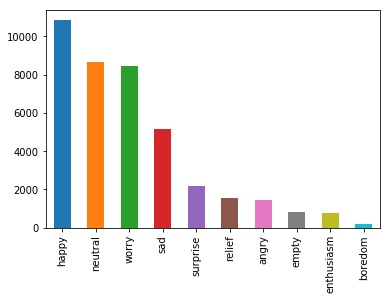

In [0]:
print(dataframes["tweets"].iloc[654])
print()
dataframes["tweets"]["sentiment"].value_counts().plot(kind='bar');
dataframes["tweets"]["sentiment"].value_counts()
dataframes["tweets"].head()

sentiment                                             angry
content      big fan found logic right support offens anyon
Name: 654, dtype: object



,sentiment,content
0,angry,hate see frown rather see smile anger
1,angry,furi patienc convers anger
2,angry,watch un speech see resent toward us american ...
3,angry,much outrag h use femal bodi sell someth anger
4,angry,shut hashtag cool offend


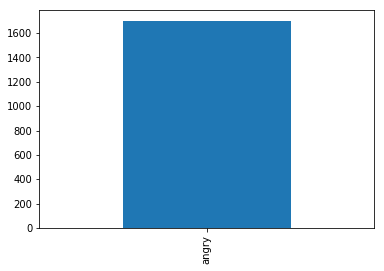

In [0]:
print(dataframes["anger-train"].iloc[654])
print()
dataframes["anger-train"]["sentiment"].value_counts().plot(kind='bar');
dataframes["anger-train"]["sentiment"].value_counts()
dataframes["anger-train"].head()

happy         12443
neutral        8638
worry          8459
sad            6698
angry          3134
surprise       2187
relief         1526
empty           827
enthusiasm      759
boredom         179
Name: sentiment, dtype: int64

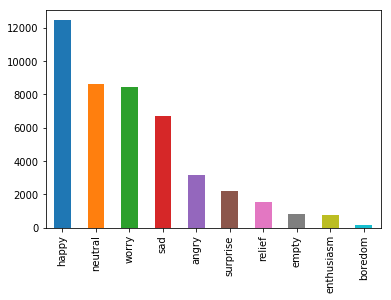

In [0]:
df_traindata = pd.concat([dataframes["tweets"], dataframes["anger-train"], dataframes["joy-train"], dataframes["sad-train"]], ignore_index=True)
#print(df_traindata)
df_traindata = df_traindata.astype(str)
df_traindata = df_traindata.reindex(np.random.permutation(df_traindata.index))

df_traindata["sentiment"].value_counts().plot(kind='bar');
df_traindata["sentiment"].value_counts()

In [0]:
#Read CSV
df_traindata = pd.read_csv("../content/drive/My Drive/Colab Notebooks/datasets/tweets+anger+joy+sad_tcs_dropped.csv", header = 0)
df_traindata.astype(str)

df_traindata = df_traindata.reindex(np.random.permutation(df_traindata.index))
# print(df_traindata)

neutral    6698
happy      6698
sad        6698
angry      3134
Name: sentiment, dtype: int64

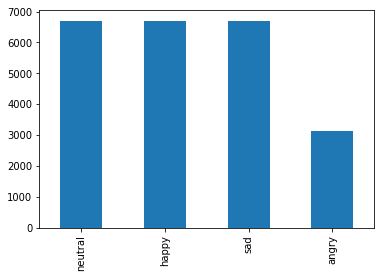

In [7]:
df_counts = df_traindata["sentiment"].value_counts()

#Make different counts equal
s_count, h_count, n_count, a_count = [0 for _ in range(4)]
# min_count = min(df_counts["happy"], df_counts["angry"], df_counts["neutral"], df_counts["sad"])
min_count = min(df_counts["happy"], df_counts["neutral"], df_counts["sad"])
for index, row in df_traindata.iterrows():
  sentiment = row["sentiment"]
  if (sentiment == "sad"):
    if (s_count < min_count):
      s_count+=1
      continue
    else:
      df_traindata.drop(index,inplace=True)
      continue
  if (sentiment == "happy"):
    if (h_count < min_count):
      h_count+=1
      continue
    else:
      df_traindata.drop(index, inplace=True)
      continue
  if (sentiment == "neutral"):
    if (n_count < min_count):
      n_count+=1
      continue
    else:
      df_traindata.drop(index, inplace=True)
      continue
  if (sentiment == "angry"):
#     if (a_count < min_count):
#       a_count+=1
#       continue
#     else:
#       df_traindata.drop(index, inplace=True)
      continue
  df_traindata.drop(index, inplace=True)
    
print()
#print(s_count, min_count)
#plot distribution of sentiments
df_traindata["sentiment"].value_counts().plot(kind='bar');
df_traindata["sentiment"].value_counts()

In [0]:
# Saving to file
name = "tweets+anger+joy+sad"
df_traindata.to_csv("../content/drive/My Drive/Colab Notebooks/datasets/" + name + "_tcs_dropped.csv", index=False)

In [0]:
def train_seq_model(x_train,
                    y_train,
                    x_val,
                    y_val,
                    input_shape,
                    learning_rate=1e-3,
                    epochs=1000,
                    batch_size=128,
                    blocks=2,
                    filters=64,
                    dropout_rate=0.2,
                    embedding_dim=200,
                    kernel_size=3,
                    pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    TOP_K = 20000
    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
#     num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance.
    model = models.Sequential()
    model.add(Dense(512, input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4))
    model.add(Activation('softmax')) #The softmax function

    # Compile model with learning parameters.
    loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adamax(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]
    model.summary()
    # Train and validate model.
    history = model.fit(
            x_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, y_val),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    y_pred = model.predict_classes(x_val)
    print(classification_report(y_val, y_pred))
    
    # Save model.
    model.save("../content/drive/My Drive/Colab Notebooks/models/model-ngramS.h5")
    return history['val_acc'][-1], history['val_loss'][-1]

In [0]:
data_x = df_traindata["content"]
data_y = df_traindata["sentiment"]

# Get the data.
train_texts, val_texts, train_labels, val_labels = train_test_split(data_x, data_y, stratify=data_y, test_size = 0.10, random_state = 42)
# print(train_texts)
# Vectorize texts.
x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)
# print(x_train)
x_seq_train, x_seq_val, word_index = sequence_vectorize(train_texts, val_texts)
# print(x_seq_train[0])
# print(word_index)

#Transform text labels to hot-encoded matrix labels
# [angry, happy, neutral, sad]
encoder = LabelEncoder()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_val = encoder.transform(val_labels)

# Call this to hot-encode matrix labels
# not needed for sparse_categorical_crossentropy
# 1. 0. 0. 0. 
# 0. 1. 0. 0.
# 0. 0. 1. 0.
# 0. 0. 0. 1.
# num_classes = np.max(y_train) + 1
# y_train = utils.to_categorical(y_train, num_classes)
# y_val = utils.to_categorical(y_val, num_classes)
# print(y_train)

In [0]:
# print(x_train[0].shape)

(1, 19778)


In [0]:
# train_ngram_model(x_train, y_train, x_val, y_val, units = 64, learning_rate=0.95e-3, layers=2, dropout_rate = 0.4, epochs=300)

Train on 20905 samples, validate on 2323 samples
Epoch 1/300
 - 7s - loss: 1.3754 - acc: 0.2894 - val_loss: 1.3652 - val_acc: 0.2983
Epoch 2/300
 - 6s - loss: 1.3582 - acc: 0.3027 - val_loss: 1.3502 - val_acc: 0.3250
Epoch 3/300
 - 6s - loss: 1.3459 - acc: 0.3182 - val_loss: 1.3387 - val_acc: 0.4167
Epoch 4/300
 - 6s - loss: 1.3366 - acc: 0.3329 - val_loss: 1.3298 - val_acc: 0.4791
Epoch 5/300
 - 6s - loss: 1.3281 - acc: 0.3428 - val_loss: 1.3219 - val_acc: 0.5024
Epoch 6/300
 - 6s - loss: 1.3206 - acc: 0.3540 - val_loss: 1.3142 - val_acc: 0.4968
Epoch 7/300
 - 6s - loss: 1.3127 - acc: 0.3605 - val_loss: 1.3065 - val_acc: 0.4963
Epoch 8/300
 - 7s - loss: 1.3069 - acc: 0.3695 - val_loss: 1.2992 - val_acc: 0.5062
Epoch 9/300
 - 7s - loss: 1.2975 - acc: 0.3740 - val_loss: 1.2914 - val_acc: 0.5170
Epoch 10/300
 - 6s - loss: 1.2902 - acc: 0.3749 - val_loss: 1.2834 - val_acc: 0.5217
Epoch 11/300
 - 6s - loss: 1.2830 - acc: 0.3767 - val_loss: 1.2755 - val_acc: 0.5235
Epoch 12/300
 - 6s - loss

(0.5970728, 1.019198226405278)

In [12]:
train_seq_model(x_train, y_train, x_val, y_val, x_train.shape[1:], learning_rate=0.995e-3, dropout_rate = 0.4, epochs=200)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               10240512  
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 10,242,564
Trainable params: 10,242,564
Non-trainable params: 0
_________

(0.60740423, 0.9899426602721985)

In [0]:
# num_features = min(len(word_index) + 1, 20000)
# lmodel = sepcnn_model(blocks=2,
#                       filters=64,
#                       kernel_size=3,
#                       embedding_dim=200,
#                       pool_size=3,
#                       dropout_rate=0.4,
#                       input_shape=x_seq_train.shape[1:],
#                       num_features=num_features)

# # Compile model with learning parameters.
# loss = 'sparse_categorical_crossentropy'
# optimizer = tf.keras.optimizers.Adamax(lr=1e-3)
# lmodel.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

# # Create callback for early stopping on validation loss. If the loss does
# # not decrease in two consecutive tries, stop training.
# callbacks = [tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=2)]

# lmodel.summary()

# # Train and validate model.
# history = lmodel.fit(
#         x_seq_train,
#         y_train,
#         epochs=300,
#         callbacks=callbacks,
#         validation_data=(x_seq_val, y_val),
#         verbose=2,  # Logs once per epoch.
#         batch_size=128)

# lmodel.compile(optimizer='adamax',
#               loss='sparse_categorical_crossentropy',
#               metrics=['acc'])

# history = history.history
# print('Validation accuracy: {acc}, loss: {loss}'.format(
#         acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

# y_pred = lmodel.predict_classes(x_seq_val)

# # Save model.
# lmodel.save("../content/drive/My Drive/Colab Notebooks/models/model-sepcnn.h5")
# print(classification_report(y_val, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 26, 200)           3511400   
_________________________________________________________________
dropout_23 (Dropout)         (None, 26, 200)           0         
_________________________________________________________________
separable_conv1d_32 (Separab (None, 26, 64)            13464     
_________________________________________________________________
separable_conv1d_33 (Separab (None, 26, 64)            4352      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
separable_conv1d_34 (Separab (None, 8, 128)            8512      
_________________________________________________________________
separable_conv1d_35 (Separab (None, 8, 128)            16896     
__________